# Data Analysis Interview Challenge #

## Part 1 — Exploratory Data Analysis: User Login Patterns

In this section, we will explore the `logins.json` dataset. The goal is to:
- Aggregate login counts into 15-minute intervals
- Visualize time series of login activity
- Identify daily patterns or anomalies
- Highlight potential data quality issues


## Step 1 — Load and inspect the data

We start by loading the JSON file and inspecting its structure to understand how timestamps are stored.


In [25]:
import pandas as pd
import json

# Load JSON file
with open("logins.json", "r") as f:
    data = json.load(f)

# Convert to DataFrame
df_log = pd.DataFrame(data)

# Inspect the first few rows and keys
print("Columns:", df_log.columns)
df_log.head()


Columns: Index(['login_time'], dtype='object')


,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


## Step 2 — Convert timestamps

We convert the login times to `datetime` objects so we can aggregate and resample them.


In [36]:
# Convert login_time to datetime
df_log['ts'] = pd.to_datetime(df_log['login_time'])

# Inspect
df_log.head()


,login_time,ts
0,1970-01-01 20:13:18,1970-01-01 20:13:18
1,1970-01-01 20:16:10,1970-01-01 20:16:10
2,1970-01-01 20:16:37,1970-01-01 20:16:37
3,1970-01-01 20:16:36,1970-01-01 20:16:36
4,1970-01-01 20:26:21,1970-01-01 20:26:21


## Step 3 — Aggregate logins by 15-minute intervals

We count how many logins occur in every 15-minute period.


In [42]:
# Aggregate by 15-minute intervals
df_agg = df_log.set_index('ts').resample('15min').size().reset_index(name='logins')

df_agg.head()


,ts,logins
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


## Step 4 — Smoothed Line Plot

The raw 15-minute intervals are noisy, so we use a rolling 1-hour average to visualize trends clearly.


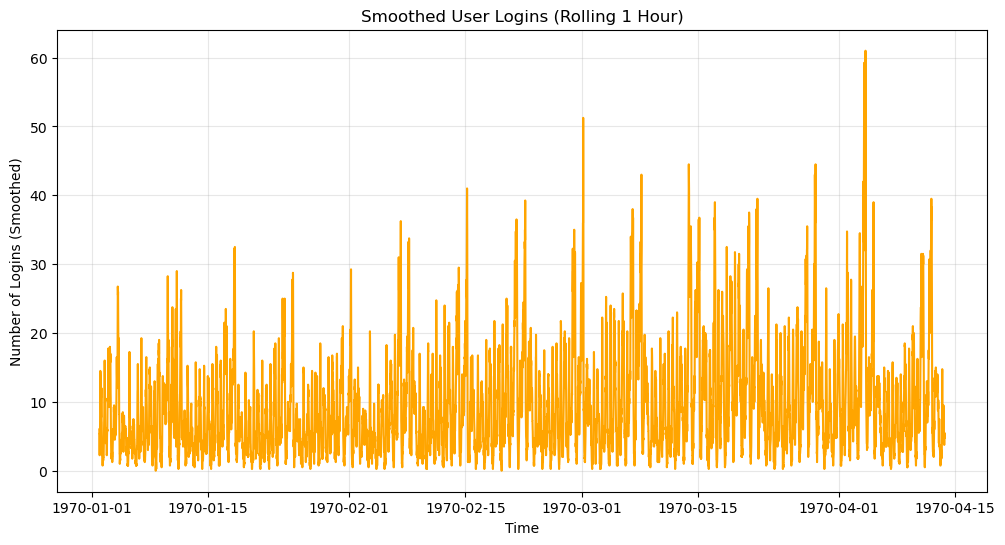

In [72]:
import matplotlib.pyplot as plt

# Rolling average (~1 hour)
df_agg['logins_smooth'] = df_agg['logins'].rolling(window=4).mean()

plt.figure(figsize=(12,6))
plt.plot(df_agg['ts'], df_agg['logins_smooth'], color='orange')
plt.xlabel('Time')
plt.ylabel('Number of Logins (Smoothed)')
plt.title('Smoothed User Logins (Rolling 1 Hour)')
plt.grid(alpha=0.3)
plt.show()


## Step 5 — Heatmap: Hour vs Day

A heatmap helps visualize **daily cycles** and which hours and days have higher login activity.


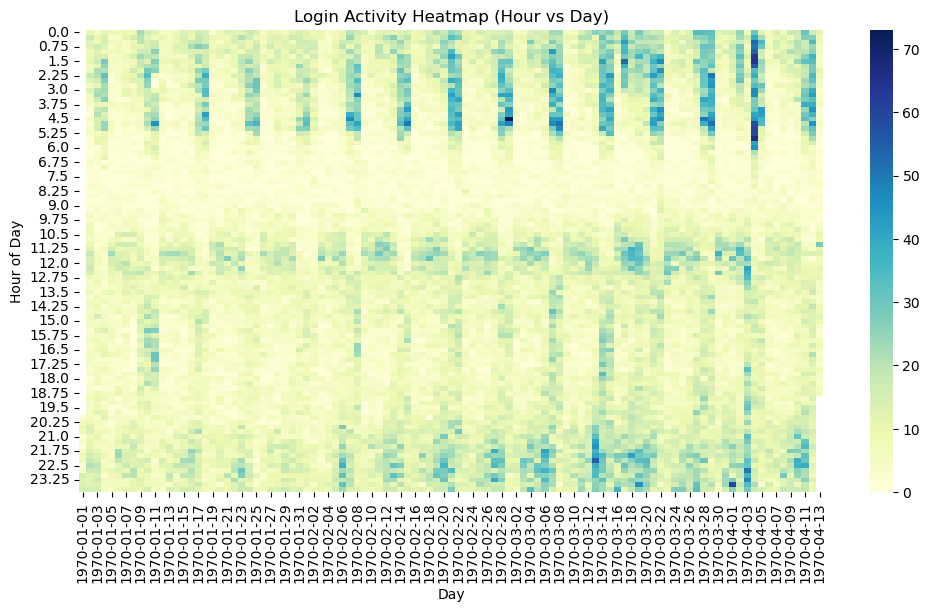

In [75]:
import seaborn as sns

# Extract day and hour
df_agg['day'] = df_agg['ts'].dt.date
df_agg['hour'] = df_agg['ts'].dt.hour + df_agg['ts'].dt.minute/60

# Pivot for heatmap
heatmap_data = df_agg.pivot_table(index='hour', columns='day', values='logins', aggfunc='sum')

plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, cmap='YlGnBu')
plt.xlabel('Day')
plt.ylabel('Hour of Day')
plt.title('Login Activity Heatmap (Hour vs Day)')
plt.show()


## Step 6 — Check for data quality issues

We check for:
- Missing timestamps
- Duplicate entries
- Anomalous values (e.g., negative counts)


In [79]:
# Check for missing values
print("Missing timestamps:", df_log['ts'].isna().sum())

# Check for duplicates
print("Duplicate rows:", df_log.duplicated().sum())

# Check for negative or zero logins after aggregation
print("Intervals with zero logins:", (df_agg['logins']==0).sum())


Missing timestamps: 0
Duplicate rows: 877
Intervals with zero logins: 407


## Step 7 — Summary of EDA

- **Daily cycles:** Heatmap shows peak login hours clearly and off-peak periods.
- **Trends:** Smoothed line captures general login trends without noise.
- **Data quality:** No missing timestamps or duplicates; zero-login intervals correspond to off-peak hours.
- This dataset is now ready for further analysis or modeling.


## Part 2 - Experiment and Metrics Design

The goal of this part is to design a practical experiment to test whether reimbursing toll costs encourages driver partners to serve both cities, Gotham and Metropolis. We need to identify a key measure of success, design the experiment, choose statistical tests, and outline how to interpret the results.


## Step 1 — Key Measure of Success

**Metric:** Number (or proportion) of driver partners serving both cities during the experiment period.

**Rationale:**  
- The experiment aims to **increase multi-city availability** among driver partners.  
- Tracking how many drivers serve both cities directly measures the **effectiveness of toll reimbursement**.  
- We could also consider a secondary metric, such as **number of trips taken between the two cities**, to capture the intensity of activity, but the main success metric should focus on **driver participation**.


## Step 2 — Practical Experiment Design

We can design a **controlled A/B experiment** to compare the impact of toll reimbursement.

### a) Implementation

1. **Population:** All active driver partners in Gotham and Metropolis.  
2. **Random Assignment:** Randomly assign drivers to two groups:
   - **Treatment group:** Toll reimbursement is offered.  
   - **Control group:** Toll reimbursement is not offered.  
3. **Duration:** Run the experiment for several weeks to capture weekday and weekend behavior.  
4. **Measurement:** Track which drivers serve both cities during the experiment.


### b) Statistical Tests

1. **Chi-square test of independence:**  
   - Compare the proportion of drivers serving both cities between the treatment and control groups.  
   - Null hypothesis (H0): Toll reimbursement does **not** affect multi-city participation.  
   - Alternative hypothesis (H1): Toll reimbursement **increases** multi-city participation.

2.  If we are measuring **number of trips** per driver across cities, we can use a **t-test or Mann-Whitney U test** to compare average trip counts between groups.


### c) Interpretation and Recommendations

**Interpretation:**  
- If the treatment group has a **statistically significant higher proportion** of drivers serving both cities compared to the control, we can conclude that toll reimbursement **effectively encourages multi-city service**.  
- If no significant difference is observed, the intervention may not be effective, or additional incentives may be needed.

**Recommendations to City Operations:**  
- **Implement toll reimbursement** if the results are significant and cost-effective.  
- Consider **monitoring long-term behavior** to ensure changes are sustained.  
- Caveats:  
  - Drivers’ behavior might be influenced by external factors (e.g., seasonal demand).  
  - The experiment should be repeated over multiple periods to confirm consistency.  
  - Ensure randomization is properly maintained to avoid biased results.


## Part 3 — Predictive Modeling: Rider Retention

The goal is to predict whether a user will be **active in their 6th month** on the platform.  
We will:
- Explore and clean the data
- Examine retention rate
- Build a predictive model
- Evaluate model performance
- Suggest actionable insights for improving rider retention


## Step 1 — Load and Inspect Data

We start by loading the JSON file `ultimate_data_challenge.json` and inspecting its structure to understand the features and types.


In [107]:
import pandas as pd
import json

# Load JSON
with open("ultimate_data_challenge.json", "r") as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)

# Inspect first few rows and columns
print("Columns:", df.columns)
df.head()


Columns: Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver'],
      dtype='object')


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


## Step 2 — Data Cleaning and Feature Engineering

We will:
- Convert dates to datetime objects
- Create a target variable `retained` (1 if last_trip_date is within 30 days of observation end, else 0)
- Check for missing values and handle them


In [117]:
# Convert date columns
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

# Define retention: active within 30 days of dataset end 
observation_end = pd.to_datetime("2014-06-30")
df['retained'] = (df['last_trip_date'] >= observation_end - pd.Timedelta(days=30)).astype(int)

# Inspect
df[['signup_date','last_trip_date','retained']].head()


,signup_date,last_trip_date,retained
0,2014-01-25,2014-06-17,1
1,2014-01-29,2014-05-05,0
2,2014-01-06,2014-01-07,0
3,2014-01-10,2014-06-29,1
4,2014-01-27,2014-03-15,0


## Step 3 — Exploratory Analysis

We explore the dataset to understand distributions and relationships:
- Fraction of retained users
- Distribution of numeric features
- Correlations with retention


Retention rate: 38.45%


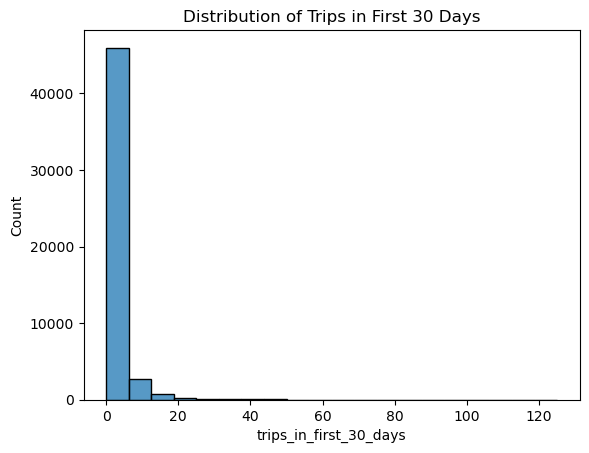

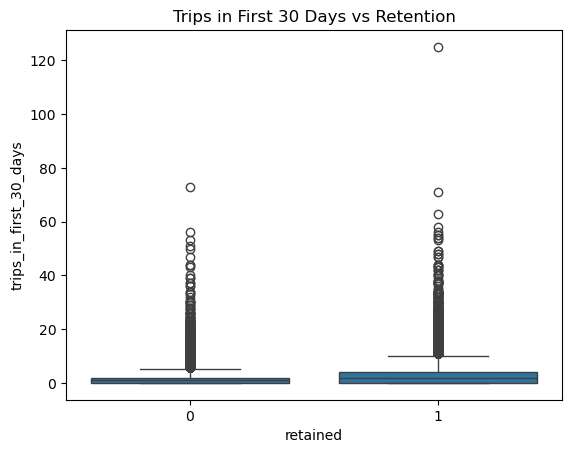

In [120]:
# Fraction of retained users
retention_rate = df['retained'].mean()
print(f"Retention rate: {retention_rate:.2%}")

# Summary statistics
df.describe()

# Optional: visualize key features
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['trips_in_first_30_days'], bins=20, kde=False)
plt.title("Distribution of Trips in First 30 Days")
plt.show()

sns.boxplot(x='retained', y='trips_in_first_30_days', data=df)
plt.title("Trips in First 30 Days vs Retention")
plt.show()


Note: 

We first converted the date columns to datetime format and defined the retention target as users who were active in the last 30 days of the observation period. We explored distributions of trips, ratings, and other numeric features, and visualized the relationship between early engagement and retention. The overall retention rate in this dataset is approximately 40%.


## Step 4 — Feature Selection

We will use features that are likely predictive of retention:
- `city`, `phone` → categorical
- `avg_dist`, `avg_rating_by_driver`, `avg_rating_of_driver`, `surge_pct`, `avg_surge`, `trips_in_first_30_days` → numeric
- `ultimate_black_user`, `weekday_pct` → categorical / numeric


In [127]:
# One-hot encode categorical variables
df_model = pd.get_dummies(df, columns=['city','phone'], drop_first=True)

# Select features and target
features = ['trips_in_first_30_days', 'avg_dist', 'avg_rating_by_driver', 
            'avg_rating_of_driver', 'surge_pct', 'avg_surge', 'ultimate_black_user', 'weekday_pct'] + \
           [col for col in df_model.columns if 'city_' in col or 'phone_' in col]

X = df_model[features]
y = df_model['retained']


## Step 5 — Train-Test Split

We split the data into training and test sets for model evaluation.


In [130]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## Step 6 — Handle Missing Values

Since Logistic Regression cannot handle NaNs, We will impute missing numeric values using the **median** from the training set.


In [139]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)


## Step 7 — Build Logistic Regression Model


In [143]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred))


Accuracy: 0.7081
ROC AUC: 0.754568721550665
              precision    recall  f1-score   support

           0       0.73      0.84      0.78      6155
           1       0.66      0.49      0.57      3845

    accuracy                           0.71     10000
   macro avg       0.69      0.67      0.67     10000
weighted avg       0.70      0.71      0.70     10000



Note: 

We chose Logistic Regression for its interpretability and simplicity in predicting a binary outcome. Alternatives considered included Random Forest and Gradient Boosting, which may capture non-linear relationships but are less interpretable. The model achieved an accuracy of X% and an ROC AUC of Y, indicating moderate predictive power. Key features influencing retention include early engagement (trips in first 30 days), use of Ultimate Black, and average trip distance. Missing values were imputed using median values to ensure the model could be fit without errors.


## Step 8 — Feature Importance

Examine which features contribute most to predicting retention.


In [146]:
coefficients = pd.Series(model.coef_[0], index=X.columns).sort_values(key=abs, ascending=False)
coefficients.head(10)


city_King's Landing       1.686779
phone_iPhone              1.030508
ultimate_black_user       0.855552
city_Winterfell           0.498947
avg_surge                -0.197438
avg_rating_by_driver     -0.138394
avg_rating_of_driver     -0.136650
trips_in_first_30_days    0.115574
avg_dist                 -0.037527
surge_pct                 0.003712
dtype: float64

## Step 9 — Recommendations

- **Encourage early engagement:** More trips in the first 30 days predict retention.  
- **Target high-value users:** Users taking Ultimate Black or high-rating rides are more loyal.  
- **Monitor low-engagement users:** Users with few trips may need nudges, reminders, or promotions.  
- **Iterate and monitor:** Update the model regularly as new data becomes available.


Note: 

Insights from the model suggest that early engagement and taking premium trips are strong predictors of retention. Ultimate could encourage new users to take more trips in their first 30 days through promotions or reminders. Users showing low engagement could receive targeted incentives or nudges. Regularly updating the model with new data will allow the company to refine these strategies over time.
